In [ ]:
# Transfer learning of a pre-trained resnet image classifier

# Uses checkpoints from https://github.com/n2cholas/jax-resnet

# https://www.machinelearningnuggets.com/transfer-learning-with-jax-flax
# https://github.com/mlnuggets/flax
# https://www.kaggle.com/code/yashvi/transfer-learning-using-jax-flax/

# https://github.com/google/flax/discussions/1565
# https://github.com/google/flax/discussions/1706

# Setup

In [1]:
import jax
print(jax.devices())

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [71]:
# pip install flax

import os
#import cv2
import numpy as np
import pandas as pd
from PIL import Image
from typing import Callable
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from PIL import Image
import jax
import optax
import flax
import jax.numpy as jnp
from jax import jit
from jax import lax
from jax_resnet import pretrained_resnet, slice_variables, Sequential
from flax.training import train_state
from flax.training.common_utils import shard
from flax.jax_utils import replicate, unreplicate

from flax import linen as nn
from flax.core import FrozenDict,frozen_dict

from functools import partial
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
%matplotlib inline
# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
resnet_tmpl, params = pretrained_resnet(50)


Using cache found in /home/kpmurphy/.cache/torch/hub/pytorch_vision_v0.6.0


# Data

We will fine-tune the ResNet model to predict two classes from the cats and dogs dataset. Download and extract the cat and dog images.
https://www.kaggle.com/c/dogs-vs-cats

In [8]:
img_dir = "/home/kpmurphy/data/cats-dogs/train"

In [5]:
if False:
  %pip install wget
  import wget 
  wget.download("https://ml.machinelearningnuggets.com/train.zip")
  import zipfile
  with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=88934e3682826e741fcb8f7c1cb3ad28764813dc17b817a8c135c4bd67d55e7c
  Stored in directory: /home/kpmurphy/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Now we make a pytorch dataloader.
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [11]:

if False: 
    train_df = pd.DataFrame(columns=["img_path","label"])
    train_df["img_path"] = os.listdir(img_dir)
    for idx, i in enumerate(os.listdir(img_dir)):
        if "cat" in i:
            train_df["label"][idx] = 0
        if "dog" in i:
            train_df["label"][idx] = 1

    #train_df.to_csv (r'train_csv.csv', index = False, header=True)
    csv_fname = os.path.join(img_dir, 'train_csv.csv')
    train_df.to_csv (csv_fname, index = False, header=True)


In [10]:
csv_fname = os.path.join(img_dir, 'train_csv.csv')

df = pd.read_csv(csv_fname)

df.head()

,img_path,label
0,cat.1386.jpg,0
1,cat.11487.jpg,0
2,dog.5910.jpg,1
3,cat.9706.jpg,0
4,cat.1186.jpg,0


In [15]:
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))
    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])
    return imgs, labels

In [12]:
config = {
    'NUM_LABELS': 2,
    'BATCH_SIZE': 32,
    'N_EPOCHS': 5,
    'LR': 0.001,
    'IMAGE_SIZE': 224,
    'WEIGHT_DECAY': 1e-5,
    'FREEZE_BACKBONE': True,
}

In [13]:
ndata = len(df)
print(ndata)
ntrain = 20000
nval = 5000



25000


In [16]:
transform = transforms.Compose([
    transforms.Resize((config["IMAGE_SIZE"],config["IMAGE_SIZE"])),
    np.array])
dataset = CatsDogsDataset(img_dir, csv_fname, transform=transform)
train_set, validation_set = torch.utils.data.random_split(dataset,[ntrain, nval], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train_set, collate_fn=custom_collate_fn, shuffle=True, batch_size=config["BATCH_SIZE"])
validation_loader = DataLoader(dataset=validation_set,collate_fn=custom_collate_fn, shuffle=False, batch_size=config["BATCH_SIZE"])

In [89]:
print(np.power(2,10))
print(np.power(2,20))

1024
1048576


In [92]:
ndata = len(dataset)
print(ndata)
(img, label) = dataset[0]
print(img.shape)

# space to store entire dataset as a matrix
nfloats = np.prod(img.shape)*ndata
nmega = nfloats*4/np.power(2,20)
print(nmega)

25000
(224, 224, 3)
14355.46875


# Network

In [17]:
"""
reference - https://www.kaggle.com/code/alexlwh/happywhale-flax-jax-tpu-gpu-resnet-baseline
"""
class Head(nn.Module):
    '''head model'''
    batch_norm_cls: partial = partial(nn.BatchNorm, momentum=0.9)
    @nn.compact
    def __call__(self, inputs, train: bool):
        output_n = inputs.shape[-1]
        x = self.batch_norm_cls(use_running_average=not train)(inputs)
        x = nn.Dropout(rate=0.25)(x, deterministic=not train)
        x = nn.Dense(features=output_n)(x)
        x = nn.relu(x)
        x = self.batch_norm_cls(use_running_average=not train)(x)
        x = nn.Dropout(rate=0.5)(x, deterministic=not train)
        x = nn.Dense(features=config["NUM_LABELS"])(x)
        return x

In [18]:
class Model(nn.Module):
    '''Combines backbone and head model'''
    backbone: Sequential
    head: Head
        
    def __call__(self, inputs, train: bool):
        x = self.backbone(inputs)
        # average pool layer
        x = jnp.mean(x, axis=(1, 2))
        x = self.head(x, train)
        return x

In [93]:
def get_backbone_and_params(model_arch: str):
    '''
    Get backbone and params
    1. Loads pretrained model
    2. Get model and param structure except last 2 layers
    3. Extract the corresponding subset of the variables dict
    INPUT : model_arch
    RETURNS backbone , backbone_params
    '''
    if model_arch == 'resnet50':
        resnet_tmpl, params = pretrained_resnet(50)
        model = resnet_tmpl()
    elif model_arch == 'resnet18':
        resnet_tmpl, params = pretrained_resnet(18)
        model = resnet_tmpl()
    else:
        raise NotImplementedError
        
    # get model & param structure for backbone
    start, end = 0, len(model.layers) - 2
    backbone = Sequential(model.layers[start:end])
    backbone_params = slice_variables(params, start, end)
    return backbone, backbone_params

In [97]:
def make_feature_extractor(depth=50):
    #backbone, backbone_params = get_backbone_and_params('resnet50')
    resnet_tmpl, params = pretrained_resnet(depth)
    model = resnet_tmpl()
    start, end = 0, len(model.layers) - 2
    backbone = Sequential(model.layers[start:end])
    backbone_params = slice_variables(params, start, end)
    
    def feature_extractor(inputs):
        xspatial = backbone.apply(backbone_params, inputs, mutable=False) # (N, 7, 7, 2048)
        # average pool layer
        x = jnp.mean(xspatial, axis=(1, 2))
        return x
    return feature_extractor

inputs = jnp.ones((5, config["IMAGE_SIZE"], config["IMAGE_SIZE"], 3), jnp.float32)
feature_extractor = make_feature_extractor()
out = feature_extractor(inputs)
print(out.shape)


Using cache found in /home/kpmurphy/.cache/torch/hub/pytorch_vision_v0.6.0


(5, 2048)


In [21]:
def get_model_and_variables(model_arch: str, head_init_key: int):
    '''
    Get model and variables 
    1. Initialise inputs(shape=(1,image_size,image_size,3))
    2. Get backbone and params
    3. Apply backbone model and get outputs
    4. Initialise head
    5. Create final model using backbone and head
    6. Combine params from backbone and head
    
    INPUT model_arch, head_init_key
    RETURNS  model, variables 
    '''
    
    #backbone
    inputs = jnp.ones((1, config['IMAGE_SIZE'],config['IMAGE_SIZE'], 3), jnp.float32)
    backbone, backbone_params = get_backbone_and_params(model_arch)
    backbone_output = backbone.apply(backbone_params, inputs, mutable=False)
    
    #head
    head_inputs = jnp.ones((1, backbone_output.shape[-1]), jnp.float32)
    head = Head()
    key = jax.random.PRNGKey(head_init_key)
    head_params = head.init(key, head_inputs, train=False)
    
    #final model
    model = Model(backbone, head)
    variables = FrozenDict({
        'params': {
            'backbone': backbone_params['params'],
            'head': head_params['params']
        },
        'batch_stats': {
            'backbone': backbone_params['batch_stats'],
            'head': head_params['batch_stats']
        }
    })
    return model, variables

In [22]:
model, variables = get_model_and_variables('resnet50', 0)
#model, variables = get_model_and_variables('resnet18', 0)

Using cache found in /home/kpmurphy/.cache/torch/hub/pytorch_vision_v0.6.0


In [23]:
inputs = jnp.ones((5, config["IMAGE_SIZE"], config["IMAGE_SIZE"], 3), jnp.float32)
key = jax.random.PRNGKey(0)
out = model.apply(variables, inputs, train=False, mutable=False)
print(out.shape)

(5, 2)


# Optimizer

In [24]:
"""
reference - https://github.com/deepmind/optax/issues/159#issuecomment-896459491
"""
def zero_grads():
    '''
    Zero out the previous gradient computation
    '''
    def init_fn(_): 
        return ()
    def update_fn(updates, state, params=None):
        return jax.tree_map(jnp.zeros_like, updates), ()
    return optax.GradientTransformation(init_fn, update_fn)
 
"""
reference - https://colab.research.google.com/drive/1g_pt2Rc3bv6H6qchvGHD-BpgF-Pt4vrC#scrollTo=TqDvTL_tIQCH&line=2&uniqifier=1
"""
def create_mask(params, label_fn):
    def _map(params, mask, label_fn):
        for k in params:
            if label_fn(k):
                mask[k] = 'zero'
            else:
                if isinstance(params[k], FrozenDict):
                    mask[k] = {}
                    _map(params[k], mask[k], label_fn)
                else:
                    mask[k] = 'adam'
    mask = {}
    _map(params, mask, label_fn)
    return frozen_dict.freeze(mask)

In [25]:
adamw = optax.adamw(
    learning_rate=config['LR'],
    b1=0.9, b2=0.999, 
    eps=1e-6, weight_decay=1e-2
)
optimizer = optax.multi_transform(
    {'adam': adamw, 'zero': zero_grads()},
    create_mask(variables['params'], lambda s: s.startswith('backbone'))
)

In [26]:
def cross_entropy_loss(*, logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=config["NUM_LABELS"])
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

In [27]:
def compute_loss(params, batch_stats, images, labels):
    logits,batch_stats = model.apply({'params': params,'batch_stats': batch_stats},images, train=True,
        rngs={'dropout': jax.random.PRNGKey(0)}, mutable=['batch_stats'])
    loss = cross_entropy_loss(logits=logits, labels=labels)
    return loss, (logits, batch_stats)

In [28]:
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [29]:
class TrainState(train_state.TrainState):
    batch_stats: FrozenDict
    
state = TrainState.create(
    apply_fn = model.apply,
    params = variables['params'],
    tx = optimizer,
    batch_stats = variables['batch_stats'],
)

In [30]:
@jax.jit
def train_step(state: TrainState,images, labels):
  """Train for a single step."""
  (batch_loss, (logits, batch_stats)), grads= jax.value_and_grad(compute_loss, has_aux=True)(state.params,state.batch_stats, images,labels)
  state = state.apply_gradients(grads=grads) 
  metrics = compute_metrics(logits=logits, labels=labels) 
  return state, metrics

In [31]:
def train_one_epoch(state, dataloader):
    """Train for 1 epoch on the training set."""
    batch_metrics = []
    for cnt, (images, labels) in enumerate(dataloader):
        images = images / 255.0
        state, metrics = train_step(state, images, labels)
        batch_metrics.append(metrics)

    batch_metrics_np = jax.device_get(batch_metrics)  
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }
    return state, epoch_metrics_np

In [32]:
@jax.jit
def eval_step(batch_stats, params, images, labels):
    logits = model.apply({'params': params,'batch_stats': batch_stats}, images, train=False,rngs={'dropout': jax.random.PRNGKey(0)})
    return compute_metrics(logits=logits, labels=labels)
    
def evaluate_model(state, test_imgs, test_lbls):
    """Evaluate on the validation set."""
    metrics = eval_step(state.batch_stats,state.params, test_imgs, test_lbls)
    metrics = jax.device_get(metrics) 
    metrics = jax.tree_map(lambda x: x.item(), metrics)  
    return metrics

# Training loop

In [30]:
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms.functional as F
logdir = "/home/kpmurphy/data/logs"
writer = SummaryWriter(logdir)

ModuleNotFoundError: No module named 'tensorboard'

In [33]:
(test_images, test_labels) = next(iter(validation_loader))
test_images = test_images / 255.0

training_loss = []
training_accuracy = []
testing_loss = []
testing_accuracy = []

def train_model(epochs):
    for epoch in range(1, epochs + 1):
        train_state, train_metrics = train_one_epoch(state, train_loader)
        training_loss.append(train_metrics['loss'])
        training_accuracy.append(train_metrics['accuracy'])

        test_metrics = evaluate_model(train_state, test_images, test_labels)
        testing_loss.append(test_metrics['loss'])
        testing_accuracy.append(test_metrics['accuracy'])
    
        #writer.add_scalar('Loss/train', train_metrics['loss'], epoch)
        #writer.add_scalar('Loss/test', test_metrics['loss'], epoch)
    
        #writer.add_scalar('Accuracy/train', train_metrics['accuracy'], epoch)
        #writer.add_scalar('Accuracy/test', test_metrics['accuracy'], epoch)
    
        print(f"Epoch: {epoch}, training loss: {train_metrics['loss']}, training accuracy: {train_metrics['accuracy'] * 100}, validation loss: {test_metrics['loss']}, validation accuracy: {test_metrics['accuracy'] * 100}")
    return train_state

In [34]:
trained_model_state = train_model(1)

Epoch: 1, training loss: 0.1405777782201767, training accuracy: 96.25499844551086, validation loss: 0.3248983323574066, validation accuracy: 90.625


# Save / load model

In [35]:
from flax.training import checkpoints
ckpt_dir = '/home/kpmurphy/data'


In [36]:
checkpoints.save_checkpoint(ckpt_dir=ckpt_dir,  
                            target=trained_model_state, 
                            step=100, 
                            prefix='resnet_model',  
                            overwrite=True  
                           )

'/home/kpmurphy/data/resnet_model100'

In [37]:
loaded_model = checkpoints.restore_checkpoint(
                                             ckpt_dir=ckpt_dir,   
                                             target=state,  
                                             prefix='resnet_model'  
                                            )
                                            
loaded_model

TrainState(step=array(625, dtype=int32), apply_fn=<bound method Module.apply of Model(
    # attributes
    backbone = Sequential(
        # attributes
        layers = [ResNetStem(
            # attributes
            conv_block_cls = functools.partial(<class 'jax_resnet.common.ConvBlock'>, conv_cls=<class 'flax.linen.linear.Conv'>, norm_cls=functools.partial(<class 'flax.linen.normalization.BatchNorm'>, momentum=0.9))
        ), functools.partial(<function max_pool at 0x7fb310dad240>, window_shape=(3, 3), strides=(2, 2), padding=((1, 1), (1, 1))), ResNetBottleneckBlock(
            # attributes
            n_hidden = 64
            strides = (1, 1)
            expansion = 4
            groups = 1
            base_width = 64
            activation = relu
            conv_block_cls = functools.partial(<class 'jax_resnet.common.ConvBlock'>, conv_cls=<class 'flax.linen.linear.Conv'>, norm_cls=functools.partial(<class 'flax.linen.normalization.BatchNorm'>, momentum=0.9))
            skip_

# Evaluate

In [38]:
evaluate_model(loaded_model, test_images, test_labels)

{'accuracy': 0.90625, 'loss': 0.3248983323574066}

In [ ]:
def predict(state, images):
    logits = state.apply_fn({'params': state.params,'batch_stats': state.batch_stats},
     images, train=False, rngs={'dropout': jax.random.PRNGKey(0)})
    return logits
   

In [39]:
(test_images, test_labels) = next(iter(validation_loader))
test_images = test_images / 255.0

logits = predict(loaded_model, test_images)
print(logits.shape)

(32, 2)


(32, 224, 224, 3)
<class 'numpy.ndarray'>
torch.Size([32, 3, 224, 224])
torch.Size([3, 906, 1810])
prediction
[[0 1 0 0 0 0 1 0]
 [0 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1 1]
 [1 0 1 0 0 0 0 0]]
truth
[[0. 1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0.]]


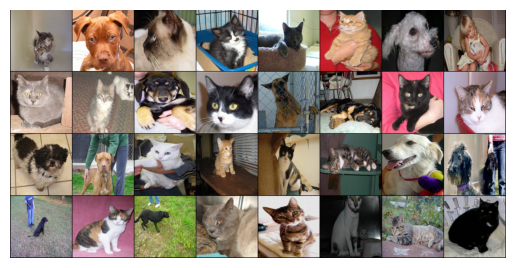

In [60]:
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
# https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t

from torchvision.utils import make_grid 
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

print(test_images.shape)
print(type(test_images))

# permute from jax (N, H, W, C) to torch (N, C, H, W)
test_images_torch = torch.tensor(test_images).permute(0, 3, 1, 2)
print(test_images_torch.shape)
ncols = 8
grid = make_grid(test_images_torch, nrow=ncols) # nrow is number of images per row = ncols
print(grid.shape)


# reshape and plot (because matplotlib needs channel as the last dimension)
plt.imshow(grid.permute(1, 2, 0));
plt.axis('off')

# extract predicted labels and reshape to match image montage 
ypred = jnp.argmax(logits, axis=1)
B  = test_images.shape[0]
nrows = int(np.ceil(B/ncols))
ypred = np.reshape(ypred, (nrows, ncols))
print('prediction')
print(ypred) # 1 = dog

print('truth')
ytrue = np.reshape(test_labels, (nrows, ncols))
print(ytrue) # 1 = dog

print('errors')
errors = (ypred != ytrue)
print(errors)


In [62]:
errors = (ypred != ytrue)
print(errors)

[[False False False False False False False  True]
 [False False False False False  True False False]
 [ True False False False False False False False]
 [False False False False False False False False]]


# PMAP training

From https://www.kaggle.com/code/yashvi/transfer-learning-using-jax-flax

In [78]:
def accuracy(logits,labels):
    return [jnp.mean(jnp.argmax(logits, -1) == labels)]

loss_fn = optax.softmax_cross_entropy
eval_fn = accuracy


class TrainState(train_state.TrainState):
    batch_stats: FrozenDict
    loss_fn: Callable = flax.struct.field(pytree_node=False)
    eval_fn: Callable = flax.struct.field(pytree_node=False)
    
# Instantiate a TrainState.
state = TrainState.create(
    apply_fn = model.apply,
    params = variables['params'],
    tx = optimizer,
    batch_stats = variables['batch_stats'],
    loss_fn = loss_fn,
    eval_fn = eval_fn
)

In [79]:
print(len(train_loader))
print(jax.local_device_count())
print(config["BATCH_SIZE"])
print(config["BATCH_SIZE"] * len(train_loader))
total_batch_size = config["BATCH_SIZE"] * jax.local_device_count()
#num_train_steps = len(train_dataset)


625
8
32
20000


In [80]:
def train_step(state: TrainState, batch, labels, dropout_rng):
    dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)
    
    # params as input because we differentiate wrt it 
    def loss_function(params):
        # if you set state.params, then params can't be backpropagated through!
        variables = {'params': params, 'batch_stats': state.batch_stats}
        
        # return mutated states if mutable is specified
        logits, new_batch_stats = state.apply_fn(
            variables, batch, train=True, 
            mutable=['batch_stats'],
            rngs={'dropout': dropout_rng}
        )
        # logits: (BS, OUTPUT_N), one_hot: (BS, OUTPUT_N)
        one_hot = jax.nn.one_hot(labels,config["NUM_LABELS"])
        loss = state.loss_fn(logits, one_hot).mean()
        return loss, (logits, new_batch_stats)
    
    
    # backpropagation and update params & batch_stats 
    grad_fn = jax.value_and_grad(loss_function, has_aux=True) #differentiate the loss function
    (loss, aux), grads = grad_fn(state.params)
    logits, new_batch_stats = aux
    grads = lax.pmean(grads, axis_name='batch') #compute the mean gradient over all devices
    new_state = state.apply_gradients(
        grads=grads, batch_stats=new_batch_stats['batch_stats'] #applies the gradients to the weights.
    )
    
    # evaluation metrics
    accuracy = state.eval_fn(logits, labels)
    
    # store metadata
    metadata = jax.lax.pmean(
        {'loss': loss, 'accuracy': accuracy},
        axis_name='batch'
    )
    return new_state, metadata, new_dropout_rng


In [81]:
def val_step(state: TrainState, batch, labels):
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    logits = state.apply_fn(variables, batch, train=False) # stack the model's forward pass with the logits function
    return state.eval_fn(logits, labels)

def test_step(state: TrainState, batch):
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    logits = state.apply_fn(variables, batch, train=False) # stack the model's forward pass with the logits function
    return logits


In [82]:


parallel_train_step = jax.pmap(train_step, axis_name='batch', donate_argnums=(0,))
parallel_val_step = jax.pmap(val_step, axis_name='batch', donate_argnums=(0,))
parallel_test_step = jax.pmap(test_step, axis_name='batch', donate_argnums=(0,))

# required for parallelism
state = replicate(state)

# control randomness on dropout and update inside train_step
rng = jax.random.PRNGKey(0)
dropout_rng = jax.random.split(rng, jax.local_device_count())  # for parallelism

In [83]:
#for epoch_i in range(config['N_EPOCHS']):
for epoch_i in range(1):
    # training set
    train_loss, train_accuracy = [], []
    
    for cnt, (batch, labels) in enumerate(train_loader):

        batch = jnp.array(batch, dtype=jnp.float32)
        labels = jnp.array(labels, dtype=jnp.float32)
        
        batch, labels = shard(batch), shard(labels)
        
        # backprop and update param & batch statsp
        
        state, train_metadata, dropout_rng = parallel_train_step(state, batch, labels, dropout_rng)
        train_metadata = unreplicate(train_metadata)
        
        # update train statistics
        _train_loss, _train_top1_acc = map(float, [train_metadata['loss'], *train_metadata['accuracy']])
        train_loss.append(_train_loss)
        train_accuracy.append(_train_top1_acc)
       
            
    avg_train_loss = sum(train_loss)/len(train_loss)
    avg_train_acc = sum(train_accuracy)/len(train_accuracy)
    print(f"[{epoch_i+1}/{config['N_EPOCHS']}] Train Loss: {avg_train_loss:.03} | Train Accuracy: {avg_train_acc:.03}")
    


[1/5] Train Loss: 0.361 | Train Accuracy: 0.871


# Feature extractor

In [ ]:
def make_feature_extractor(depth=50):
    #backbone, backbone_params = get_backbone_and_params('resnet50')
    resnet_tmpl, params = pretrained_resnet(depth)
    model = resnet_tmpl()
    start, end = 0, len(model.layers) - 2
    backbone = Sequential(model.layers[start:end])
    backbone_params = slice_variables(params, start, end)
    
    def feature_extractor(inputs):
        xspatial = backbone.apply(backbone_params, inputs, mutable=False) # (N, 7, 7, 2048)
        # average pool layer
        x = jnp.mean(xspatial, axis=(1, 2))
        return x
    return feature_extractor

inputs = jnp.ones((5, config["IMAGE_SIZE"], config["IMAGE_SIZE"], 3), jnp.float32)
feature_extractor = make_feature_extractor()
out = feature_extractor(inputs)
print(out.shape)
nfeatures = out.shape[1]

In [125]:
def extract_features(feature_extractor, dataloader, max_batches=None):
    ndata = len(dataloader)
    X  = []
    y = []
    for batch_num, (images, labels) in enumerate(dataloader):
        if max_batches is not None:
            if batch_num >= max_batches:
                break
        print('batch num', batch_num)
        images = images / 255.0
        out = feature_extractor(images)
        batch_size, nfeatures = out.shape
        X.append(out)
        y.append(np.reshape(labels, (batch_size,)))
    return jnp.concatenate(X), np.concatenate(y)

    

In [127]:
print(len(train_loader))
print(len(validation_loader))
X, Y =  extract_features(feature_extractor, validation_loader, 2)
print(X.shape)
print(Y.shape)

625
157
batch num 0
batch num 1
(64, 2048)
(64,)
